In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pylab as plt
import sklearn.cross_validation as skcv
import sklearn.linear_model as sklin
import sklearn.preprocessing as skprep
import sklearn.metrics as skmetrics
from sklearn.svm import SVC,NuSVC
import csv,math
import pandas as pd


In [2]:
# read training and testing csv files
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
train_dataframe = pd.read_hdf("train.h5", "train")
test_dataframe = pd.read_hdf("test.h5", "test")

train_data=train_dataframe.values
test_data=test_dataframe.values

Id_test=test_dataframe.axes[0]
#print(type(train_dataframe.blocks))
#print((test_dataframe.axes[0]))

print('train data dim =',train_data.shape)
print('test data dim =',test_data.shape)
#print('1st sample in training data:',train_data[0])
#print('1st sample in testing data:',test_data[0])

X_train_ori=train_data[:,1:train_data.shape[1]]
Y_train_ori=train_data[:,0]
X_test=test_data

print('1st sample in training data:',X_train_ori[0])
print('1st 10 samples in training labels:',Y_train_ori[0:10])
print('1st sample in testing data:',X_test[0])


print('X_train dim =',X_train_ori.shape)
print('Y_train dim =',Y_train_ori.shape)
print('X_test dim =',X_test.shape)


train data dim = (45324, 101)
test data dim = (8137, 100)
1st sample in training data: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.625       0.          0.75        0.          0.          0.
  0.          0.          0.46875     0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.0859375   0.          0.
  0.          0.          0.          0.95703125  0.          0.          0.
  0.          0.          0.          0.          0.          0.8984375   0.
  0.          0.          0.234375    0.          0.          0.          0.
  0.          0.9921875   0.          0.          0.          0.  

In [3]:
# feature extraction


#10% for validation
sample_size=Y_train_ori.shape[0]
testing_ind=list(np.random.randint(0,sample_size,sample_size*0.1))
training_ind= list(set(range(0,sample_size))-set(testing_ind))
print(max(training_ind))
X_train=[X_train_ori[i] for i in training_ind]
Y_train=[Y_train_ori[i] for i in training_ind]
X_val=[X_train_ori[i] for i in testing_ind]
Y_val=[Y_train_ori[i] for i in testing_ind]

X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_val=np.asarray(X_val)
Y_val=np.asarray(Y_val)

print('X_train dim =',X_train.shape)
print('Y_train dim =',Y_train.shape)
print('X_val dim =',X_val.shape)

#polynomial features
#poly = skprep.PolynomialFeatures(2)
#X_train=poly.fit_transform(X_train)
#X_val=poly.fit_transform(X_val)
#X_test=poly.fit_transform(X_test)


45323
X_train dim = (40991, 100)
Y_train dim = (40991,)
X_val dim = (4532, 100)


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [4]:
# normalization
X_train=skprep.normalize(X_train,norm='max',axis=1)
X_val=skprep.normalize(X_val,norm='max',axis=1)
X_test=skprep.normalize(X_test,norm='max',axis=1)

In [5]:
Y_train[1]

4.0

In [6]:
# ############################# Batch iterator ###############################
# Function taken from mnist.py in Lasagne examples
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [89]:
# build classification model - using Lasagne
# maybe try stacking many dense layers first???
import theano
import theano.tensor as T
import os
import time

import lasagne

batch_size = 128
num_epochs = 30
n_layers=6
rows=X_train.shape[0]
cols=X_train.shape[1]
history={'acc': [], 'loss': [],'val_acc':[],'val_loss':[]}


print('Build model...')
# Prepare Theano variables for inputs and targets
input_var = T.matrix('inputs')
target_var = T.ivector('targets')

# First, build input layer,specifying the expected input shape of the network
# (batchsize, input size)
# linking it to the given Theano variable `input_var`
# dim(input_var) must be equal to dim(shape)
# batchsize=None so that we will be able to feed in batches of varying size

model = lasagne.layers.InputLayer(shape=(None,cols),
                                        input_var=input_var)

# Retrieve symbolic references to the input variable's shape, i.e. batchsize 
batchsize, _ = model.input_var.shape
# non linearity
nonlin = [lasagne.nonlinearities.rectify,lasagne.nonlinearities.tanh, lasagne.nonlinearities.ScaledTanh,
              lasagne.nonlinearities.softmax
              ,lasagne.nonlinearities.LeakyRectify(0.1), lasagne.nonlinearities.sigmoid]
nonlinearity = [0,5,0,5,0,5]
units = [700,600,700,600,700,600]
# stack some dense layers
for layer_cnt in range(n_layers):
    model = lasagne.layers.DenseLayer(
            model,num_units=units[layer_cnt],
            #nonlinearity=lasagne.nonlinearities.rectify)
            nonlinearity=nonlin[nonlinearity[layer_cnt]])
    model = lasagne.layers.dropout(model, p=0.5)

# output layer
model = lasagne.layers.DenseLayer(
            model,num_units=5,
            nonlinearity=lasagne.nonlinearities.softmax)


print('Create functions for training & testing...')
# Create a loss expression for training,i.e., a scalar objective we want
# to minimize. use cross-entropy loss here
prediction = lasagne.layers.get_output(model)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

# Create an expression to compute training error
train_acc_fn = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. use Adam updates here
params = lasagne.layers.get_all_params(model, trainable=True)
updates = lasagne.updates.adam(loss, params)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(model, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()
# also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], [loss,train_acc_fn], updates=updates,allow_input_downcast=True)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc],allow_input_downcast=True)

# Compile a function for prediction:
pred_fn = theano.function([input_var],lasagne.layers.get_output(model, deterministic=True),allow_input_downcast=True)
print('Finish building model..')

Build model...
Create functions for training & testing...
Finish building model..


In [90]:
# launch the training loop
print("Train...")
#iterate over epochs:
num_epochs = 180
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, Y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err,acc=train_fn(inputs, targets)
        train_err+= err
        train_acc+= acc        
        train_batches += 1

    # And a full pass over the validation data (X_test, y_test)
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, Y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    #save loss and acc
    history['loss'].append(train_err / train_batches)
    history['acc'].append(train_acc / train_batches)
    history['val_loss'].append(val_err / val_batches)
    history['val_acc'].append(val_acc / val_batches)
    
    
# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_val, Y_val, batch_size, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))


Train...
Epoch 1 of 180 took 37.282s
  training loss:		1.075621
  training accuracy:		55.15 %
  validation loss:		0.458339
  validation accuracy:		84.75 %
Epoch 2 of 180 took 33.407s
  training loss:		0.443247
  training accuracy:		85.87 %
  validation loss:		0.303401
  validation accuracy:		90.60 %
Epoch 3 of 180 took 32.617s
  training loss:		0.339266
  training accuracy:		89.30 %
  validation loss:		0.262918
  validation accuracy:		91.41 %
Epoch 4 of 180 took 35.196s
  training loss:		0.297519
  training accuracy:		90.65 %
  validation loss:		0.246591
  validation accuracy:		91.81 %
Epoch 5 of 180 took 32.683s
  training loss:		0.269965
  training accuracy:		91.59 %
  validation loss:		0.235453
  validation accuracy:		92.61 %
Epoch 6 of 180 took 34.293s
  training loss:		0.249119
  training accuracy:		92.20 %
  validation loss:		0.203371
  validation accuracy:		93.44 %
Epoch 7 of 180 took 33.042s
  training loss:		0.235578
  training accuracy:		92.61 %
  validation loss:		0.197182
 

In [91]:
# predict on the test data
output= np.squeeze(pred_fn(X_test))
Y_test=np.argmax(output, axis=1) 
print(output[0])
print(Y_test.shape)
print(Y_test[0])

[  4.55190829e-05   1.35614612e-04   5.19957707e-05   5.96208735e-05
   9.99707250e-01]
(8137,)
4


In [92]:
sub = pd.read_csv("sample.csv")
sub['y'] = Y_test
sub.head()
sub.to_csv('050505x767676_9634_train9797_drop_0_5_180ep_adam_LXY.csv', index = False)

In [87]:
# use following code to load an existing model
#"""load model
with np.load('050505x700_9629_train9809_drop_0_5_180ep_adam_LXY.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(model, param_values)
#"""

In [93]:
# Save a copy of the history and the model
import pickle as pkl

print('Saving weights...')
np.savez('050505x767676_9634_train9797_drop_0_5_180ep_adam_LXY.npz', *lasagne.layers.get_all_param_values(model))
pkl.dump(history, open('050505x767676_9634_train9797_drop_0_5_180ep_adam_LXY.pkl','wb'))

Saving weights...


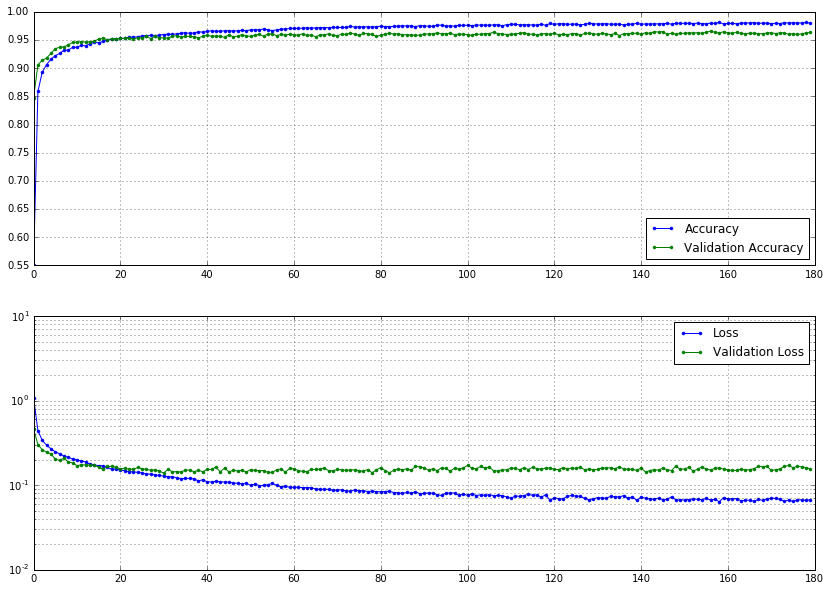

In [94]:
# Load history from file
history = pkl.load(open('050505x767676_9634_train9797_drop_0_5_180ep_adam_LXY.pkl','rb'))

plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
plt.plot(history['acc'], '.-')
plt.plot(history['val_acc'], '.-')
plt.legend(['Accuracy', 'Validation Accuracy'],loc='lower right')
plt.grid(which='both')

plt.subplot(2,1,2)
plt.semilogy(history['loss'], '.-')
plt.semilogy(history['val_loss'], '.-')
plt.legend(['Loss', 'Validation Loss'])
plt.grid(which='both')